# StackOverflow Analysis

Popular question and answer (qna) site - stackoverflow (& their sister sites - http://stackexchange.com/sites) witnesses tremendous activity daily where netizens post questions, recieve answers, comments and engage in an active discussion. 

We want to analyze this data with the intention to identify __related__ questions. In general, the analysis presented in this notebook can be used in a variety of scenarios. Some illustrative examples include

* Power users use multiple browser tabs simultaneously. Using the techniques outlined below, we can identify and group similar tabs together. With the appropriate visual cues, similar tabs can be identified at a glance.

* Many products provide a twitter handle to offer support. User questions about the product or service related queries (all within the twitter 140 char limit) can be grouped based on similarity.

The Stack Exchange network uploads monthly dumps of their data which we have used for analysis.

> "The anonymized dump of all user-contributed content on the Stack Exchange network. Each site is formatted as a separate archive consisting of XML files zipped via 7-zip using bzip2 compression. Each site archive includes Posts, Users, Votes, Comments, PostHistory and PostLinks. For complete schema information, see the included readme.txt.

> All user content contributed to the Stack Exchange network is cc-by-sa 3.0 licensed, intended to be shared and remixed. We even provide all our data as a convenient data dump."

** From : https://archive.org/details/stackexchange **


## Schema & Data Munging

The schema for their data is located @ https://ia800500.us.archive.org/22/items/stackexchange/readme.txt.
    
However,

* All the data is dumped in XML format. So we need to write a converter.
* Since the size of data is huge, we need to load data in a streaming fashion. 
* All the exchange sites share identical schema


The first step is to then write a converter which does this. Our [Streaming XML2CSV Converter](convertp2csv.py) expects input data to be present at [input/english](input/english) for english.stackexchange.com, [input/aviation](input/aviation) for aviation.stackexchange.com etc. Similarly, the converted data is dumped at [output/english](output/english) and [output/aviation](output/aviation) respectively.

Also, note the converter outputs the csv file in a zipped format as pandas (the lib we use to read data) understands zip formats natively.

In [38]:
#imports
import pandas as pd
import math
import re
import gensim
from gensim import corpora, models,similarities
from gensim.models import word2vec, doc2vec
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pprint import pprint                        # pretty-printer

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from sklearn.feature_extraction.text import TfidfVectorizer

SAMPLE_SIZE = 20000

SITE1 = 'english' #.stackoverflow.com
SITE2 = 'aviation' #.stackoverflow.com

# Data loading

For the purposes of this analysis, we use only post title and body. However, we will show the other data also made available to us from stackexchange. This can be used to further enrich the analysis. But this is not done in the current notebook.

### Note :

The original data is large. So to play around with the data, we have provide some knobs to tune within the notebooks (versus putting them in the parser)

1. ** SAMPLE_SIZE **  (#default value as 20k records)
2. ** SITE1 ** (#default value is english)
3. ** SITE2 ** (#default value is aviation)

Feel free to change this value to experiment or get better results.

In [6]:
path = 'output/'+SITE1+'/'+'posts.csv.gz'
posts_s1 = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_s1['Tags'] = posts_s1['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

path = 'output/'+SITE2+'/'+'posts.csv.gz'
posts_s2 = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Body','Title'])
posts_s2['Tags'] = posts_s2['Tags'].apply(lambda x : x.replace('<',' ').replace('>',' '))

# analyze across sites
frames = [posts_s2, posts_s1]

#analyze only one site
frames = [posts_s1]

posts = pd.concat(frames)
posts[['Body','Title', 'Tags']].head(2)


,Body,Title,Tags
0,when should i use can when should i use could...,when do i use can or could,word-choice tenses politeness subjunctive-...
1,doesn t quint mean five what does that h...,where does the quint in quintessential com...,etymology


In [8]:
path = 'output/'+SITE2+'/'+'comments.csv.gz'
comments = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna()
comments[['Score','Text']].head(5)

,Score,Text
0,0,right of course i use request all the time ...
1,1,the few times i ve spoken to military controll...
2,5,congrats on the first question on aviation
3,1,garrisonneely thanks i love the platform b...
4,1,in the u s i think the controllers would typ...


In [9]:
path='output/'+SITE1+'/'+'posthistory.csv.gz'
posthistory = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['Text'])
posthistory[['Text']].head(5)

,Text
0,when could i use can or when can i use could ...
1,when do i could can could
3,doesn t quint mean five what does that hav...
4,where does the quint in quintessential come ...
6,which is the correct use of these two words an...


In [10]:
path='output/' + SITE1 + '/' + 'users.csv.gz'
users = pd.read_csv(path,compression='gzip',nrows=SAMPLE_SIZE).dropna(subset=['AboutMe','Location'])
users[['Location','AboutMe']].head(5)

,Location,AboutMe
0,on the server farm,hi i m not really a person i m a background ...
1,corvallis or,developer on the stack overflow team find me...
2,new york ny,developer on the stack overflow team was dubb...
3,raleigh nc,i design stuff for stack exchange also a prof...
4,california,i slip my front end into the back end and the...


### Note

The relationship between all these tables and the detailed meaning of all the attributes and values can be found @
https://ia800500.us.archive.org/22/items/stackexchange/readme.txt
    

## Data cleansing - Stop Words & Word Stems

Once the data is loaded, we want to remove all the stop words present in the raw data. The ** stop_words ** instance can be used for the remainder of the program to achieve this.

In [13]:
class StopWords():
    def __init__(self):
        #p_stemmer = PorterStemmer()
        self.stop_words = stopwords.words('english')
        self.stop_words.append('use')

    def remove(self, sentence):
        #raw_tokens = filter(None, re.split("[ ]+",raw_sentence))
        #stem_tokens = [p_stemmer.stem(tok) for tok in raw_tokens]
        #yield [tok for tok in raw_tokens if not tok in stop_words and len(tok) > 1 ]
        raw_tokens = filter(None, re.split(";+| +|,+|\?+|\*+",sentence))
        return [tok for tok in raw_tokens if not tok in self.stop_words and len(tok) > 1]

stop_words = StopWords() 

In [48]:
class SentenceTokens():
    def __init__(self,df,field):
        self.field = field
        self.df = df
    
    def __iter__(self):
        for index, row in self.df.iterrows():
            raw_sentence = row[self.field]
            yield stop_words.remove(raw_sentence)
            
#all posts is a list of (list of tokens). The inner list of tokens is created once for each post
allposts = SentenceTokens(posts,'Title')
#print([p for p in allposts])
#How frequently each term occurs within each document? We construct a document-term matrix.
dictionary = corpora.Dictionary(allposts)
#bag of words
#corpus is a list of vectors equal to the number of documents. 
#In each document vector is a series of tuples. 
corpus = [dictionary.doc2bow(post) for post in allposts]            

# Approach : Bag of Words
========================================
* Take a sample question
* Remove stop words
* Convert into a vector using bag of words
* Search vector using LSI model

In [15]:
# Find similar questions by converting it into vector
samples = ['Where does the quint in quintessential come from?',
           'Where does goodness me come from?']

sampleIndex = 0
sampleVector = dictionary.doc2bow(stop_words.remove(samples[sampleIndex]))
pprint(stop_words.remove(samples[sampleIndex]))

['Where', 'quint', 'quintessential', 'come']


In [16]:
# Decide number of topics based on factors in a vector
numberOfTopics = len(sampleVector)
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=numberOfTopics)

# convert the query (sample vector) to LSI space
vec_lsi = lsi[sampleVector]

In [17]:
index = similarities.MatrixSimilarity(lsi[corpus]) 

# perform a similarity query against the corpus
sims = index[vec_lsi]

# Sort in descending order - highest matching percentage on top
sims = sorted(enumerate(sims), key=lambda item: -item[1])
sims_list = list(enumerate(sims))

# Show top 10 matches only
for i in range(0, 10):
    docid = sims_list[i][1][0]
    matchPercentage = sims_list[i][1][1]
#     print(str(matchPercentage * 100) + " : " + posts.iloc[docid]['Title'])
    print("{:10.3f}% : {}".format(matchPercentage * 100, posts.iloc[docid]['Title']))

   100.000% :  tit for tat    where does this come from 
   100.000% : where does the  quint  in  quintessential  come from 
   100.000% : where does  ta   come from 
   100.000% : where does  santa  in santa claus come from 
   100.000% : where did the  juices  in  creative juices  come from 
   100.000% : are  come round  and  visit  interchangeable 
   100.000% : where does  can t be arsed  come from 
    99.999% : did  et cetera  gain its popularity from  the king and i  
    99.998% : where does  hot damn   come from 
    99.998% : where did the saying  bite the dust  come from 


# Approach : LDA model
====================================

In [49]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=30)

#num_topics: required. An LDA model requires the user to determine how many topics should be generated. 
#id2word: required. The LdaModel class requires our previous dictionary to map ids to strings.
#passes: optional. The number of laps the model will take through corpus.

In [50]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [51]:
@interact(num_topics=5, num_words=3)
def understand(num_topics, num_words):
    return ldamodel.print_topics(num_topics, num_words)
    
#Each generated topic is separated by a comma.
#Within each topic are the three most probable words to appear in that topic.

[(18, u'0.193*difference + 0.054*plural + 0.033*form'),
 (6, u'0.031*term + 0.027*different + 0.020*origin'),
 (10, u'0.056*would + 0.055*english + 0.053*something'),
 (12, u'0.061*used + 0.041*etymology + 0.030*time'),
 (13, u'0.154*sentence + 0.051*using + 0.035*call')]

In [63]:
pyLDAvis.gensim.prepare(ldamodel,corpus,dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      6.175977        1       1 -0.242476  0.048657
10     5.972550        1       2 -0.022474  0.100456
15     5.794916        1       3  0.083900  0.173219
18     5.687826        1       4  0.067957  0.121381
14     5.310533        1       5 -0.025640 -0.055937
2      5.191562        1       6  0.089015  0.065714
5      5.118076        1       7  0.027399  0.022260
17     5.082928        1       8  0.147379 -0.125256
16     4.974549        1       9 -0.208687 -0.009967
0      4.924787        1      10  0.029618 -0.041026
13     4.895184        1      11  0.013099 -0.143380
8      4.880857        1      12 -0.003196  0.074533
12     4.841426        1      13 -0.080459 -0.080464
11     4.825616        1      14  0.065060 -0.063228
4      4.507870        1      15 -0.004894 -0.135018
7      4.476754        1      16  0.014765 -0.005252
9      4.396163        1      17 -0.011684  0.068069
19     4.391931        1      18  0.033240  0.000933
6      4.302951        1      19  0.022168  0.061830
3      4.247544        1      20  0.005910 -0.077526, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
3831  Default  235.000000     difference  235.000000  30.0000  30.0000
1418  Default  248.000000             vs  248.000000  29.0000  29.0000
5673  Default  208.000000        meaning  208.000000  28.0000  28.0000
3557  Default  204.000000        correct  204.000000  27.0000  27.0000
3304  Default  161.000000       sentence  161.000000  26.0000  26.0000
5946  Default  132.000000          usage  132.000000  25.0000  25.0000
532   Default  115.000000            one  115.000000  24.0000  24.0000
3268  Default  113.000000            say  113.000000  23.0000  23.0000
1585  Default  366.000000           word  366.000000  22.0000  22.0000
4455  Default   86.000000           like   86.000000  21.0000  21.0000
5932  Default  210.000000        english  210.000000  20.0000  20.0000
2557  Default  121.000000           used  121.000000  19.0000  19.0000
4571  Default   72.000000          would   72.000000  18.0000  18.0000
5147  Default   61.000000           come   61.000000  17.0000  17.0000
5739  Default   67.000000      something   67.000000  16.0000  16.0000
5793  Default   66.000000         plural   66.000000  15.0000  15.0000
3135  Default  267.000000           mean  267.000000  14.0000  14.0000
5646  Default   62.000000       question   62.000000  13.0000  13.0000
5193  Default   55.000000           good   55.000000  12.0000  12.0000
1626  Default   76.000000         versus   76.000000  11.0000  11.0000
2191  Default   64.000000          using   64.000000  10.0000  10.0000
5027  Default   71.000000           name   71.000000   9.0000   9.0000
4140  Default   51.000000  pronunciation   51.000000   8.0000   8.0000
1851  Default   59.000000            way   59.000000   7.0000   7.0000
1534  Default   43.000000      etymology   43.000000   6.0000   6.0000
2346  Default  125.000000         phrase  125.000000   5.0000   5.0000
5025  Default   90.000000           term   90.000000   4.0000   4.0000
5053  Default   86.000000         origin   86.000000   3.0000   3.0000
3359  Default   40.000000           form   40.000000   2.0000   2.0000
772   Default   41.000000           past   41.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
3743  Topic20    5.100073       pronouns    5.840093   3.0233  -5.1832
519   Topic20    5.087400          quite    5.827420   3.0230  -5.1857
3648  Topic20    4.675574    conjunction    5.415594   3.0119  -5.2702
2320  Topic20    4.315968         family    5.055987   3.0006  -5.3502
2011  Topic20    4.208772         domain    4.948792   2.9969  -5.3753
784   Topic20    3.998665         legend    4.738684   2.9890  -5.4265
817   Topic20    3.891

<img src='ldaop.png'>

# Approach : Doc2Vec
================================

In [27]:
class LabeledLineSentence(object):
    def __init__(self,df,field,tag):
        self.df = df
        self.field = field
        self.tag = tag

    def __iter__(self):
        for index, row in self.df.iterrows():
            tokens = stop_words.remove(row[self.field])
            yield doc2vec.TaggedDocument(words=tokens,tags=[row[self.tag]])

lablines = LabeledLineSentence(posts,'Title','Id')
# print([p for p in lablines])

In [28]:
docmodel = doc2vec.Doc2Vec(alpha=0.025, min_alpha=0.025)
docmodel.build_vocab(lablines)
for epoch in range(10):
    docmodel.train(lablines)
    docmodel.alpha -= 0.002  # decrease the learning rate
    docmodel.min_alpha = docmodel.alpha  # fix the learning rate, no decay

In [29]:
class MatchingPost(object):
    matchingPercentage = 0
    title = ""
    
    def __init__(self, matchingPercentage, title):
        self.matchingPercentage = matchingPercentage
        self.title = title
        

def showsimilar(question):
    if (type(question) is not 'str'):
        question = str(question)
        
    norm_input = stop_words.remove(question) # question.split()
    q_vector = docmodel.infer_vector(norm_input)
    similar_vecs = docmodel.docvecs.most_similar(positive=[q_vector])
    similarTitles = []
    
    for vec in similar_vecs:
        post = posts[posts['Id']==vec[0]]
        if(len(post) == 0): continue
        title = posts[posts['Id']==vec[0]]['Title']
        similarPostInfo = MatchingPost(vec[1], title.iloc[0])
        similarTitles.append(similarPostInfo)
    
    # Show top 10 matches only
    for title in similarTitles:
        post = title.title
        matchPercentage = title.matchingPercentage
        print("{:10.2f}% : {}".format(matchPercentage * 100, post))

    return similarTitles


similarTitles = showsimilar("Where does the quint in quintessential come from?")

     90.76% : which is correct   one or more is  or  one or more are  
     87.12% : what s the meaning of  get one s finger in the air  
     86.85% : what is the difference between  used to  and  i was used to  
     86.75% : what s the difference between these sentences 
     86.13% : what s the difference between these sentences 
     85.96% : how did  mad  come to be a determiner 
     85.89% : where does  santa  in santa claus come from 
     85.86% : where does the  quint  in  quintessential  come from 
     85.83% : where does  pull it off  come from 
     85.80% : where does  can t be arsed  come from 


In [31]:
from IPython.display import display
from ipywidgets import widgets 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def handler(sender):
    showsimilar(text.value)
    
text = widgets.Text()    
display(text)    
text.on_submit(handler)


# Experimental : Try TF-IDF & T-SNE 
=====================================================

In [32]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,3), min_df = 0, stop_words = 'english')
corpus = []
for index, post in posts.iterrows():
    corpus.append(post['Title']) 

tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names() 

#len(feature_names)
#feature_names[50:70]

In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf_matrix)

In [34]:
X_tsne = TSNE(learning_rate=100,n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5232
[t-SNE] Computed conditional probabilities for sample 2000 / 5232
[t-SNE] Computed conditional probabilities for sample 3000 / 5232
[t-SNE] Computed conditional probabilities for sample 4000 / 5232
[t-SNE] Computed conditional probabilities for sample 5000 / 5232
[t-SNE] Computed conditional probabilities for sample 5232 / 5232
[t-SNE] Mean sigma: 0.000593
[t-SNE] Iteration 25: error = 1.5348289, gradient norm = 0.0000099
[t-SNE] Iteration 25: gradient norm 0.000010. Finished.
[t-SNE] Iteration 50: error = 1.5347518, gradient norm = 0.0001491
[t-SNE] Iteration 50: gradient norm 0.000149. Finished.
[t-SNE] Error after 50 iterations with early exaggeration: 1.534752
[t-SNE] Iteration 75: error = 1.5346060, gradient norm = 0.0031043
[t-SNE] Iteration 100: error = 1.5322407, gradient norm = 0.0094370
[t-SNE] Iteration 125: error = 1.5297343, g

In [36]:
X_pca = PCA().fit_transform(tfidf_matrix.todense())

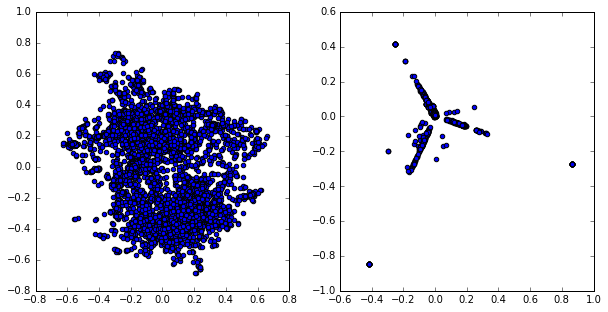

In [42]:
from matplotlib.pyplot import figure

figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1])
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1])

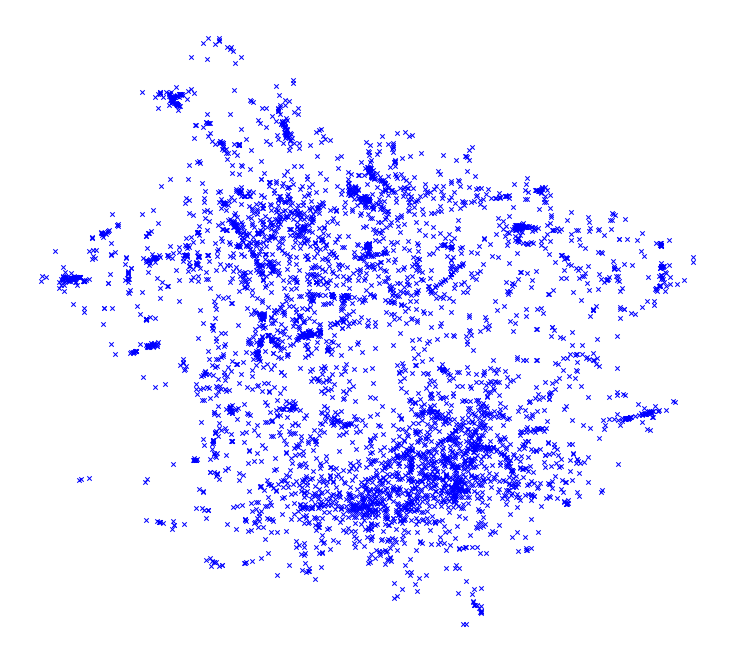

In [43]:
fig = figure(figsize=(10, 10))
ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,wspace=0.0, hspace=0.0)
scatter(X_tsne[:, 0], X_tsne[:, 1],marker="x")

# Future Directions

These are the kinds of questions we would like to pursue in the future:

* Predict the next question a user may ask based on this current search

* The raw data has user-generated tags for all the questions asked. Use supervised learning algorithms against this data set.

* Build a browser plugin for the use case discussed in the introduction

We are always live @ https://github.com/dhruvaray/soml


## References

* https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
* LDA Viz - http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
* This dashboard @ https://github.com/dhruvaray/soml
    